In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD

In [2]:
np.random.seed(52)
n = 15000

privileges = np.random.choice([0, 1], size=n, p=[.9, .1])

In [3]:
def generate_scores():
    return np.clip(np.random.normal(loc=160, scale=15, size=n), 100, 200)

math = generate_scores()
eng = generate_scores()
ukr = generate_scores()

In [4]:
rating = 0.4 * math + 0.3 * eng + 0.3 * ukr

In [5]:
df = pd.DataFrame({
    'math': math,
    'eng': eng,
    'ukr': ukr,
    'privilege': privileges,
    'rating': rating
})

In [6]:
df['accepted'] = 0

In [7]:
eligible_non_priv = df[
    (df['privilege'] == 0) &
    (df['rating'] >= 160) &
    (df['math'] >= 140) &
    (df['eng'] >= 120) &
    (df['ukr'] >= 120)
]

eligible_priv = df[
    (df['privilege'] == 1) &
    (df['rating'] >= 144) &
    (df['math'] >= 120) &
    (df['eng'] >= 120) &
    (df['ukr'] >= 120)
]

In [8]:
non_priv_n = int(n * (315/1500))
priv_n = int(n * (35/1500))

In [9]:
top_non_priv = eligible_non_priv.sort_values(by='rating', ascending=False).head(non_priv_n)
top_priv = eligible_priv.sort_values(by='rating', ascending=False).head(priv_n)

In [10]:
df.loc[top_non_priv.index, 'accepted'] = 1
df.loc[top_priv.index, 'accepted'] = 1

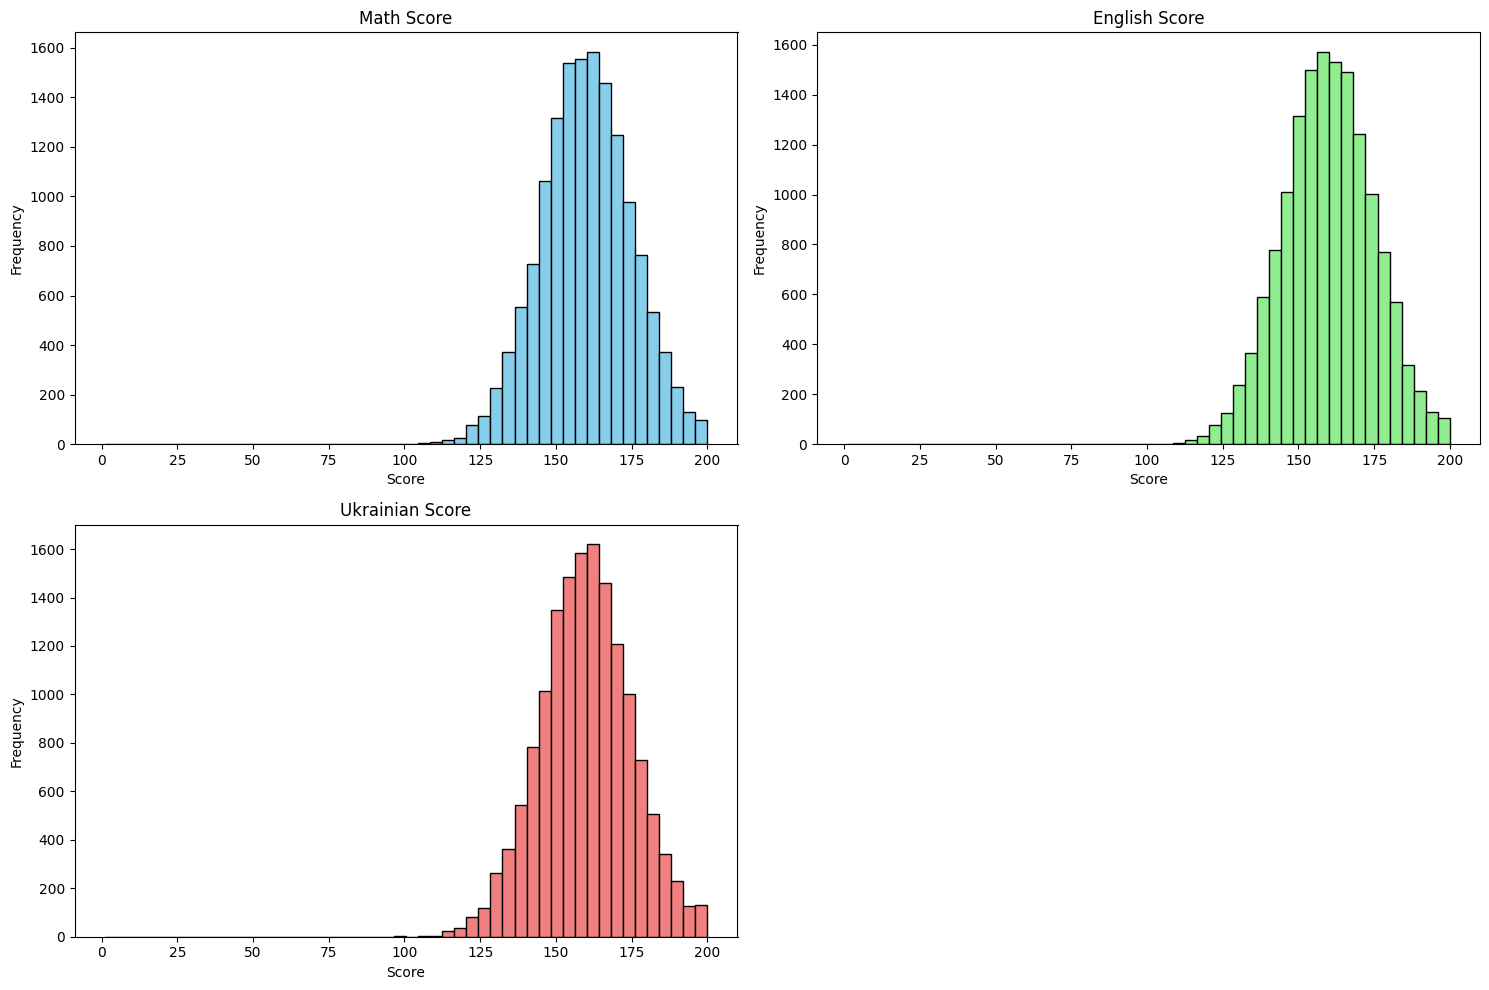

In [11]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.hist(df['math'], bins=50, range=(1, 200), color='skyblue', edgecolor='k')
plt.title('Math Score')
plt.xlabel('Score')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
plt.hist(df['eng'], bins=50, range=(1, 200), color='lightgreen', edgecolor='k')
plt.title('English Score')
plt.xlabel('Score')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
plt.hist(df['ukr'], bins=50, range=(1, 200), color='lightcoral', edgecolor='k')
plt.title('Ukrainian Score')
plt.xlabel('Score')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

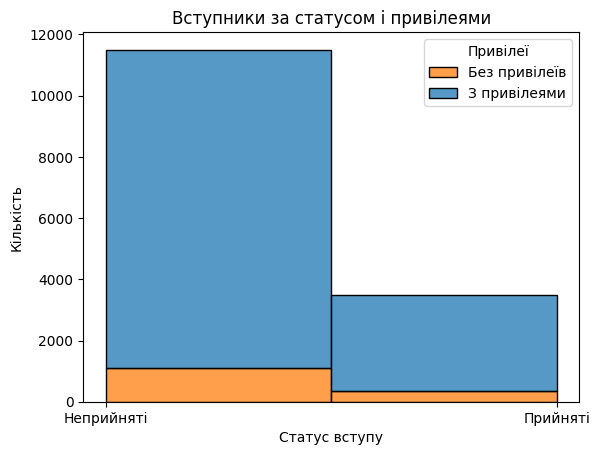

In [12]:
sns.histplot(data=df, x='accepted', hue='privilege', multiple='stack', bins=2)
plt.xticks([0, 1], ['Неприйняті', 'Прийняті'])
plt.xlabel('Статус вступу')
plt.ylabel('Кількість')
plt.title('Вступники за статусом і привілеями')
plt.legend(title='Привілеї', labels=['Без привілеїв', 'З привілеями'])
plt.show()

In [13]:
total_accepted = df['accepted'].sum()
total_rejected = len(df) - total_accepted
accepted_with_priv = df[(df['accepted'] == 1) & (df['privilege'] == 1)].shape[0]
accepted_without_priv = df[(df['accepted'] == 1) & (df['privilege'] == 0)].shape[0]

print(f"Загальна кількість заяв: {len(df)}")
print(f"✅ Прийнято: {total_accepted}")
print(f"  ├── З привілеями: {accepted_with_priv}")
print(f"  └── Без привілеїв: {accepted_without_priv}")
print(f"❌ Не прийнято: {total_rejected}")

Загальна кількість заяв: 15000
✅ Прийнято: 3500
  ├── З привілеями: 350
  └── Без привілеїв: 3150
❌ Не прийнято: 11500


In [14]:
# Отримаємо зарахованих
accepted = df[df['accepted'] == 1]
not_accepted = df[df['accepted'] == 0]

# Стратифіковане розділення лише для зарахованих (щоб зберегти частку пільговиків)
accepted_train, accepted_test = train_test_split(
    accepted,
    test_size=0.1,
    stratify=accepted['privilege'],
    random_state=52
)

# Звичайне перемішане розділення для незарахованих (опціонально, або без shuffle)
not_accepted_train, not_accepted_test = train_test_split(
    not_accepted,
    test_size=0.1,
    random_state=52,
    shuffle=True
)

# Об'єднуємо назад
train = pd.concat([accepted_train, not_accepted_train])
test = pd.concat([accepted_test, not_accepted_test])

# Перемішуємо
train = train.sample(frac=1, random_state=52).reset_index(drop=True)
test = test.sample(frac=1, random_state=52).reset_index(drop=True)

X_train = train[['math', 'eng', 'ukr', 'privilege']].values
y_train = train['accepted'].values

X_test = test[['math', 'eng', 'ukr', 'privilege']].values
y_test = test['accepted'].values

In [15]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [16]:
def build_model(arch, dropout=False, l2_reg=False, optimizer='adam'):
    model = Sequential()
    
    reg = l2(0.001) if l2_reg else None

    model.add(Input((4,)))
    # Перший шар (вхідний)
    model.add(Dense(arch[0], activation='relu', kernel_regularizer=reg))
    
    for units in arch[1:]:
        model.add(Dense(units, activation='relu', kernel_regularizer=reg))
        if dropout:
            model.add(Dropout(0.3))
    
    model.add(Dense(1, activation='sigmoid'))
    
    opt = Adam() if optimizer == 'adam' else SGD(learning_rate=0.01)
    
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

results = []

architectures = {
    "A": ([8], False, False),
    "B": ([8, 4], False, False),
    "C": ([16, 8, 4], False, False),
    "D": ([8, 4], True, False),
    "E": ([8, 4], False, True),
    "F": ([8, 4], True, True)
}

for name, (arch, dropout, l2reg) in architectures.items():
    for opt in ['adam', 'sgd']:
        model = build_model(arch, dropout, l2reg, optimizer=opt)
        history = model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0, validation_split=0.2)
        y_pred = (model.predict(X_test) > 0.5).astype(int)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        results.append({
            "Model": name,
            "Arch": str(arch),
            "Dropout": dropout,
            "L2": l2reg,
            "Optimizer": opt,
            "Accuracy": acc,
            "F1": f1
        })

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step


In [17]:
results_df = pd.DataFrame(results)
print(results_df.sort_values(by='F1', ascending=False))

   Model        Arch  Dropout     L2 Optimizer  Accuracy        F1
10     F      [8, 4]     True   True      adam  0.998667  0.997135
2      B      [8, 4]    False  False      adam  0.998000  0.995708
6      D      [8, 4]     True  False      adam  0.997333  0.994302
8      E      [8, 4]    False   True      adam  0.996667  0.992908
0      A         [8]    False  False      adam  0.996667  0.992847
9      E      [8, 4]    False   True       sgd  0.996667  0.992847
1      A         [8]    False  False       sgd  0.996667  0.992826
4      C  [16, 8, 4]    False  False      adam  0.996000  0.991404
5      C  [16, 8, 4]    False  False       sgd  0.989333  0.977208
3      B      [8, 4]    False  False       sgd  0.984000  0.965909
7      D      [8, 4]     True  False       sgd  0.977333  0.949555
11     F      [8, 4]     True   True       sgd  0.976667  0.947683


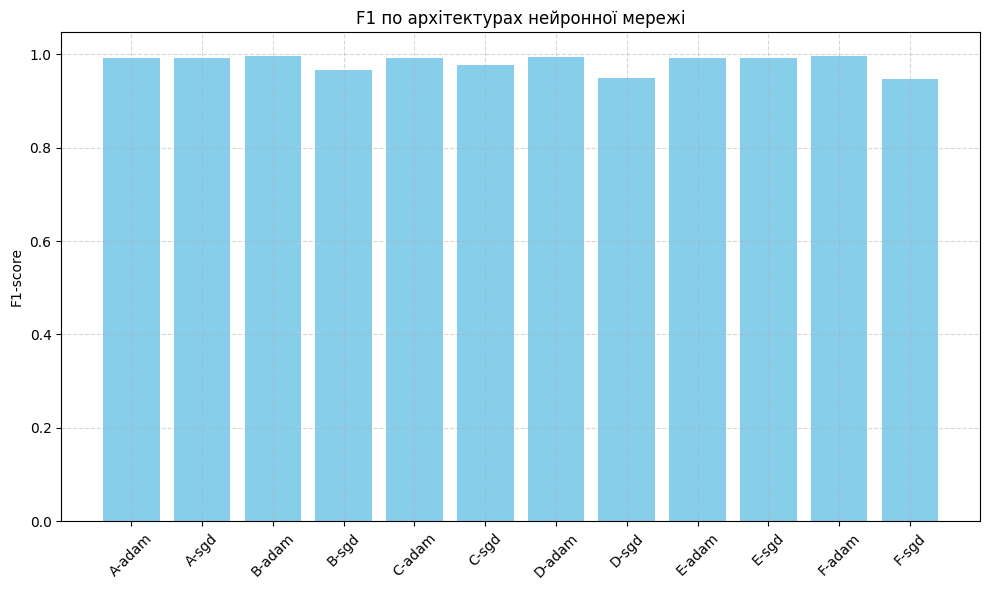

In [18]:
plt.figure(figsize=(10, 6))
plt.bar(results_df['Model'] + '-' + results_df['Optimizer'], results_df['F1'], color='skyblue')
plt.xticks(rotation=45)
plt.ylabel("F1-score")
plt.title("F1 по архітектурах нейронної мережі")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("f1_by_model.png")
plt.show()

In [19]:
best_model_info = results_df.sort_values(by='F1', ascending=False).iloc[0]
best_model_name = best_model_info['Model']
print("Найкраща модель:", best_model_info)

Найкраща модель: Model               F
Arch           [8, 4]
Dropout          True
L2               True
Optimizer        adam
Accuracy     0.998667
F1           0.997135
Name: 10, dtype: object


In [20]:
best_arch = eval(best_model_info['Arch'])
best_dropout = best_model_info['Dropout']
best_l2 = best_model_info['L2']
best_opt = best_model_info['Optimizer']

In [21]:
best_model = build_model(best_arch, dropout=best_dropout, l2_reg=best_l2, optimizer=best_opt)
history = best_model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2)

Epoch 1/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7325 - loss: 0.5900 - val_accuracy: 0.9607 - val_loss: 0.2608
Epoch 2/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step - accuracy: 0.8876 - loss: 0.2687 - val_accuracy: 0.9815 - val_loss: 0.1320
Epoch 3/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - accuracy: 0.9057 - loss: 0.1797 - val_accuracy: 0.9852 - val_loss: 0.0950
Epoch 4/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - accuracy: 0.9118 - loss: 0.1549 - val_accuracy: 0.9900 - val_loss: 0.0785
Epoch 5/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - accuracy: 0.9137 - loss: 0.1427 - val_accuracy: 0.9930 - val_loss: 0.0695
Epoch 6/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - accuracy: 0.9250 - loss: 0.1267 - val_accuracy: 0.9937 - val_loss: 0.0636
Epoch 7/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - accuracy: 0.9619 - loss: 0.1227 - val_accuracy: 0.9919 - val_loss: 0.0589
Epoch 8/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step - accuracy: 0.9626 - loss: 0.1188 - va

In [22]:
best_model.save('best_admission_model.h5')
print("Модель збережена у файлі best_admission_model.h5")

Модель збережена у файлі best_admission_model.h5


In [23]:
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f"Точність на тестовій вибірці: {accuracy:.4f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - accuracy: 0.9976 - loss: 0.0336
Точність на тестовій вибірці: 0.9973


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
Accuracy: 0.9973
Precision: 0.9983
Recall: 0.9943
F1-score: 0.9963


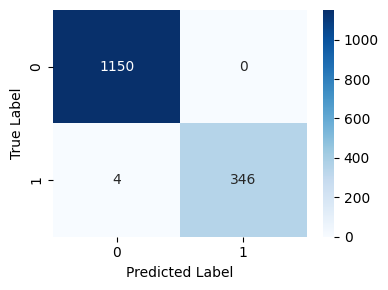

In [24]:
y_pred = (best_model.predict(X_test) > 0.5).astype("int32")
report = classification_report(y_test, y_pred, output_dict=True)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {report["macro avg"]["precision"]:.4f}")
print(f"Recall: {report["macro avg"]["recall"]:.4f}")
print(f"F1-score: {report["macro avg"]["f1-score"]:.4f}")

plt.figure(figsize=(4, 3))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

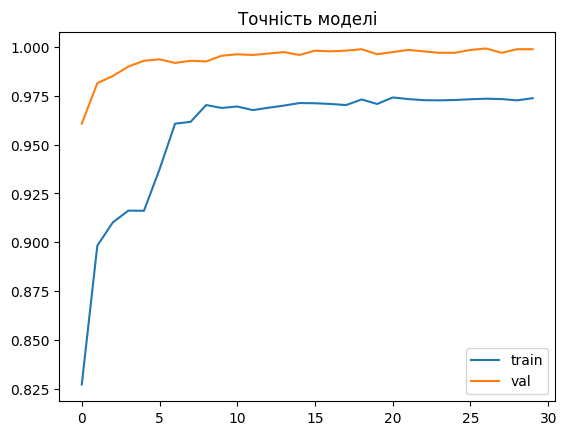

In [25]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.title("Точність моделі")
plt.show()

In [26]:
# Приклад одного "аномального" абітурієнта
sample = np.array([[200, 200, 100, 0]])  # Без пільг
sample_scaled = scaler.transform(sample)  # масштабування, як для train-даних

prediction = best_model.predict(sample_scaled)
predicted_label = (prediction > 0.5).astype(int)

print(f"Ймовірність зарахування: {prediction[0][0]:.4f}")
print(f"Клас: {'Зараховано' if predicted_label[0][0] == 1 else 'Не зараховано'}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Ймовірність зарахування: 0.9774
Клас: Зараховано


In [27]:
test['prediction_prob'] = best_model.predict(X_test)
test['predicted'] = (test['prediction_prob'] > 0.5).astype(int)

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step


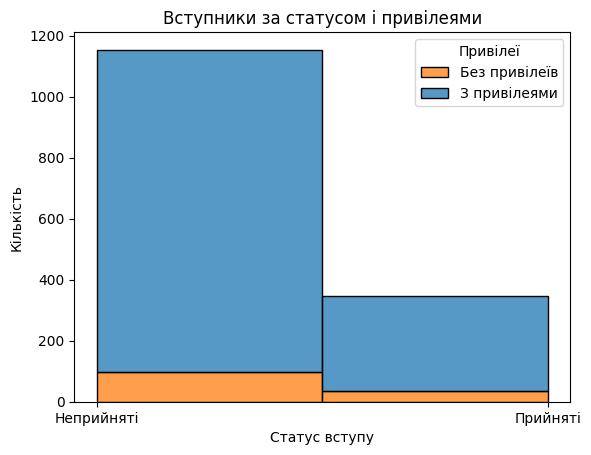

In [28]:
sns.histplot(data=test, x='predicted', hue='privilege', multiple='stack', bins=2)
plt.xticks([0, 1], ['Неприйняті', 'Прийняті'])
plt.xlabel('Статус вступу')
plt.ylabel('Кількість')
plt.title('Вступники за статусом і привілеями')
plt.legend(title='Привілеї', labels=['Без привілеїв', 'З привілеями'])
plt.show()

In [29]:
total_predicted_accepted = test['predicted'].sum()
total_predicted_rejected = len(test) - total_predicted_accepted
predicted_accepted_with_priv = test[(test['predicted'] == 1) & (test['privilege'] == 1)].shape[0]
predicted_accepted_without_priv = test[(test['predicted'] == 1) & (test['privilege'] == 0)].shape[0]

print(f"Загальна кількість заяв: {len(test)}")
print(f"✅ Прийнято: {total_predicted_accepted}")
print(f"  ├── З привілеями: {predicted_accepted_with_priv}")
print(f"  └── Без привілеїв: {predicted_accepted_without_priv}")
print(f"❌ Не прийнято: {total_predicted_rejected}")

Загальна кількість заяв: 1500
✅ Прийнято: 346
  ├── З привілеями: 34
  └── Без привілеїв: 312
❌ Не прийнято: 1154


In [30]:
df_final = test.sort_values(by='rating', ascending=False)

In [31]:
df_final

,math,eng,ukr,privilege,rating,accepted,prediction_prob,predicted
162,196.706002,184.209121,197.505953,0,193.196923,1,1.000000e+00,1
62,200.000000,188.098963,170.222206,0,187.496351,1,9.999999e-01,1
1138,191.080006,171.196104,188.451648,1,184.326328,1,9.999998e-01,1
459,193.698640,185.029430,171.029059,0,184.297003,1,9.999993e-01,1
1345,183.077489,175.801223,186.568466,0,181.941903,1,9.999977e-01,1
...,...,...,...,...,...,...,...,...
994,148.630400,127.275569,129.760725,0,136.563048,0,6.495912e-31,0
1432,136.271187,130.726183,141.617240,0,136.211502,0,1.163703e-31,0
17,125.967997,129.735344,154.443891,0,135.640969,0,1.430728e-32,0
353,124.297520,129.862333,153.040633,0,134.589898,0,1.688468e-33,0


In [32]:
df_final[['math', 'eng', 'ukr', 'privilege', 'rating', 'prediction_prob']].to_csv("accepted_applicants.csv", index=False)